In [94]:
import numpy as np
import pandas as pd
from joblib import dump
from functools import partial
from sklearn.experimental import enable_halving_search_cv
from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
from xgboost import XGBClassifier
import category_encoders as ce
import optuna

### Settings

In [2]:
SEED = 1990
TEST_RATIO = 1 / 4

### Train-Test Split

In [3]:
data = pd.read_pickle("classification_dataset.pkl")
X = data.drop("target", axis=1)
y = data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=SEED, stratify=y
)

In [5]:
y_train.value_counts(normalize=True)

0    0.7
1    0.3
Name: target, dtype: float64

### Define Pipeline

In [6]:
pipen = Pipeline([("numeric", StandardScaler())])

In [7]:
pipec = Pipeline([("categorical", ce.CatBoostEncoder())])

In [8]:
prepro = ColumnTransformer(
    [
        ("num", pipen, make_column_selector(dtype_include=np.number)),
        ("cat", pipec, make_column_selector(dtype_include=object)),
    ]
)

### Add model to the Pipeline

In [9]:
model = Pipeline([("prp", prepro), ("clf", XGBClassifier())])

### cross_val_score

In [10]:
cvscore1 = cross_val_score(model, X_train, y_train, scoring="f1", cv=3)
cvscore1

array([0.82191781, 0.73291925, 0.75167785])

### cross_validate

In [11]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score),
    "f2": make_scorer(fbeta_score, beta=2),
    "f0.5": make_scorer(fbeta_score, beta=0.5),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "roc_auc": make_scorer(roc_auc_score),
    "pr_auc": make_scorer(average_precision_score),
    "log_loss": make_scorer(log_loss),
}

In [12]:
cvscore2 = cross_validate(
    model,
    X_train,
    y_train,
    scoring=scoring,
    cv=3,
    return_train_score=True,
)
cvscore2

{'fit_time': array([0.07151079, 0.04081607, 0.03913808]),
 'score_time': array([0.00856423, 0.00705695, 0.00710487]),
 'test_accuracy': array([0.896, 0.828, 0.852]),
 'train_accuracy': array([0.964, 0.994, 0.982]),
 'test_f1': array([0.82191781, 0.73291925, 0.75167785]),
 'train_f1': array([0.93918919, 0.98996656, 0.9704918 ]),
 'test_f2': array([0.80862534, 0.7642487 , 0.7486631 ]),
 'train_f2': array([0.93163539, 0.98798398, 0.98013245]),
 'test_f0.5': array([0.8356546 , 0.70405728, 0.75471698]),
 'train_f0.5': array([0.94686649, 0.9919571 , 0.96103896]),
 'test_precision': array([0.84507042, 0.68604651, 0.75675676]),
 'train_precision': array([0.95205479, 0.99328859, 0.95483871]),
 'test_recall': array([0.8       , 0.78666667, 0.74666667]),
 'train_recall': array([0.92666667, 0.98666667, 0.98666667]),
 'test_roc_auc': array([0.86857143, 0.81619048, 0.82190476]),
 'train_roc_auc': array([0.95333333, 0.99190476, 0.98333333]),
 'test_pr_auc': array([0.73605634, 0.60368992, 0.64104505])

In [13]:
pd.DataFrame(cvscore2)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_f2,train_f2,test_f0.5,train_f0.5,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_pr_auc,train_pr_auc,test_log_loss,train_log_loss
0,0.071511,0.008564,0.896,0.964,0.821918,0.939189,0.808625,0.931635,0.835655,0.946866,0.845070,0.952055,0.800000,0.926667,0.868571,0.953333,0.736056,0.904237,3.748540,1.297572
1,0.040816,0.007057,0.828,0.994,0.732919,0.989967,0.764249,0.987984,0.704057,0.991957,0.686047,0.993289,0.786667,0.986667,0.816190,0.991905,0.603690,0.984045,6.199508,0.216262
2,0.039138,0.007105,0.852,0.982,0.751678,0.970492,0.748663,0.980132,0.754717,0.961039,0.756757,0.954839,0.746667,0.986667,0.821905,0.983333,0.641045,0.946108,5.334461,0.648786


### RandomizedSearchCV

* RandomizedSearchCV [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* this will sample **n_iter** from the params_grid; each grid will be evaluated with cross-validation on **cv** folds
* the output will return the results **cv** results, corresponding to the evaluation on the different folds
* output will contain the test fold(s) results and potentially the train folds - if **return_train_score**
* **refit** : Refit an estimator using the best found parameters on the whole dataset.
* if **refit** is used, the best params_grid examined will be selected based on the **refit** value to train the estimator on the **entire dataset**
* **cv** : For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with shuffle=False so the splits will be the same across calls.

In [14]:
params_grid = {
    "clf__n_estimators": [100, 150, 200],
    "clf__learning_rate": [0.01, 0.1, 0.5],
    "clf__max_depth": [3, 5, 7],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 0.3, 0.5],
    "clf__reg_alpha": [0.1, 0.25, 0.75],
    "clf__reg_lambda": [0.1, 0.25, 0.75],
}

In [15]:
search1 = RandomizedSearchCV(
    estimator=model,
    param_distributions=params_grid,
    n_iter=20,
    scoring=scoring,
    refit="accuracy",
    cv=3,
    verbose=1,
    return_train_score=True,
    random_state=SEED,
)

In [16]:
search1.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prp',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('numeric',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x15fb99dc0>),
                                                                              ('cat',
                                                                               Pipeline(steps=[('categorical',
                                                                                                CatBoostEncoder())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x15...
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f0.5': make_scorer(fbeta_score, beta=0.5),
                            'f1': make_scorer(f1_score),
                            'f2': make_scorer(fbeta_score, beta=2),
                            'log_loss': make_scorer(log_loss),
                            'pr_auc': make_scorer(average_precision_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)},
                   verbose=1)

In [17]:
[x for x in dir(search1) if not x.startswith('_')]

['best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_iter',
 'n_jobs',
 'n_splits_',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'score_samples',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [18]:
search1.best_estimator_

Pipeline(steps=[('prp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15ebe84c0>),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical',
                                                                   CatBoostEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15fb99f10>)])),
                ('clf',
                 XGBClassifier(...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [19]:
search1.best_params_

{'clf__subsample': 0.6,
 'clf__reg_lambda': 0.1,
 'clf__reg_alpha': 0.1,
 'clf__n_estimators': 200,
 'clf__min_child_weight': 1,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.01,
 'clf__gamma': 0,
 'clf__colsample_bytree': 0.6}

In [20]:
search1.best_index_

12

In [21]:
search1.best_score_

0.88

In [22]:
search1.cv_results_

{'mean_fit_time': array([0.07745926, 0.04916898, 0.0379777 , 0.04976209, 0.0474902 ,
        0.05118402, 0.05787063, 0.0606602 , 0.06104207, 0.06439384,
        0.02864965, 0.04900432, 0.0441308 , 0.04712462, 0.0371964 ,
        0.05189919, 0.02743093, 0.07342307, 0.06935827, 0.03789687]),
 'std_fit_time': array([0.02052346, 0.00782913, 0.00335033, 0.0017121 , 0.0015511 ,
        0.00631979, 0.00839056, 0.0034722 , 0.02776904, 0.00244659,
        0.00194736, 0.00183359, 0.00340783, 0.00113767, 0.00101826,
        0.00062245, 0.00042515, 0.00028076, 0.01740613, 0.00116196]),
 'mean_score_time': array([0.00779279, 0.00729593, 0.00676433, 0.0069232 , 0.00682934,
        0.00745646, 0.00783364, 0.00911029, 0.00724467, 0.01021584,
        0.00669702, 0.00686264, 0.00730332, 0.00680971, 0.00909162,
        0.00685771, 0.0083073 , 0.00692662, 0.00754976, 0.0082914 ]),
 'std_score_time': array([7.37304983e-04, 2.94397960e-04, 2.99265709e-06, 2.82107384e-05,
        3.23408648e-05, 7.67810795e-

In [23]:
search1df = pd.DataFrame(search1.cv_results_)
search1df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__subsample,param_clf__reg_lambda,param_clf__reg_alpha,param_clf__n_estimators,param_clf__min_child_weight,param_clf__max_depth,...,split1_test_log_loss,split2_test_log_loss,mean_test_log_loss,std_test_log_loss,rank_test_log_loss,split0_train_log_loss,split1_train_log_loss,split2_train_log_loss,mean_train_log_loss,std_train_log_loss
0,0.077459,0.020523,0.007793,0.000737,1.0,0.75,0.1,150,3,3,...,4.325238,5.046111,4.613588,0.311453,16,3.964802,3.388103,3.604365,3.652424,0.237876
1,0.049169,0.007829,0.007296,0.000294,0.6,0.1,0.25,100,5,5,...,6.343683,5.190286,5.286402,0.826825,6,4.036889,3.892715,3.964802,3.964802,0.058859
2,0.037978,0.003350,0.006764,0.000003,0.6,0.25,0.1,150,1,3,...,6.343683,4.901937,5.238344,0.801290,8,2.090532,0.720873,1.297572,1.369659,0.561479
3,0.049762,0.001712,0.006923,0.000028,0.8,0.75,0.1,150,1,5,...,6.343683,5.334461,5.094170,1.131156,13,1.802183,0.288349,0.865048,0.985193,0.623832
4,0.047490,0.001551,0.006829,0.000032,0.8,0.25,0.25,200,1,3,...,4.469413,4.901937,4.421355,0.413412,19,3.892715,3.460191,3.316016,3.556307,0.245050
5,0.051184,0.006320,0.007456,0.000768,0.8,0.1,0.1,100,1,3,...,4.469413,5.190286,4.565529,0.475752,17,4.253151,3.748540,3.532278,3.844656,0.302041
6,0.057871,0.008391,0.007834,0.000618,0.6,0.25,0.1,200,3,7,...,6.920381,4.613588,5.430577,1.055094,2,2.234707,1.369659,1.585921,1.730095,0.367575
7,0.060660,0.003472,0.009110,0.002378,0.6,0.25,0.25,200,3,7,...,5.911159,4.901937,4.901937,0.824027,15,3.748540,2.739318,3.027667,3.171841,0.424439
8,0.061042,0.027769,0.007245,0.000391,0.6,0.25,0.1,100,3,7,...,5.911159,5.190286,5.382519,0.378411,4,3.676453,2.883492,3.460191,3.340045,0.334687
9,0.064394,0.002447,0.010216,0.002355,0.8,0.75,0.25,200,5,7,...,6.055334,5.190286,5.190286,0.706308,11,3.676453,2.883492,3.316016,3.291987,0.324170


In [24]:
search1df.shape

(20, 113)

In [25]:
search1df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__subsample', 'param_clf__reg_lambda', 'param_clf__reg_alpha',
       'param_clf__n_estimators', 'param_clf__min_child_weight',
       'param_clf__max_depth',
       ...
       'split1_test_log_loss', 'split2_test_log_loss', 'mean_test_log_loss',
       'std_test_log_loss', 'rank_test_log_loss', 'split0_train_log_loss',
       'split1_train_log_loss', 'split2_train_log_loss', 'mean_train_log_loss',
       'std_train_log_loss'],
      dtype='object', length=113)

In [26]:
search1df.filter(like='mean_',axis=1)

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_f2,mean_train_f2,mean_test_f0.5,mean_train_f0.5,mean_test_precision,mean_train_precision,mean_test_recall,mean_train_recall,mean_test_roc_auc,mean_train_roc_auc,mean_test_pr_auc,mean_train_pr_auc,mean_test_log_loss,mean_train_log_loss
0,0.077459,0.007793,0.872000,0.898667,0.763029,0.816835,0.716586,0.777501,0.816633,0.860403,0.857277,0.892155,0.688889,0.753333,0.819683,0.857143,0.683585,0.746194,4.613588,3.652424
1,0.049169,0.007296,0.853333,0.890000,0.752687,0.811328,0.746183,0.797660,0.759911,0.825654,0.765155,0.835597,0.742222,0.788889,0.821587,0.861111,0.645784,0.722360,5.286402,3.964802
2,0.037978,0.006764,0.854667,0.962000,0.761513,0.935778,0.765617,0.932754,0.758315,0.939490,0.756657,0.942360,0.768889,0.931111,0.830159,0.953175,0.650863,0.898001,5.238344,1.369659
3,0.049762,0.006923,0.858667,0.972667,0.769966,0.954595,0.777039,0.955164,0.763665,0.954050,0.759858,0.953699,0.782222,0.955556,0.836825,0.967778,0.660920,0.925441,5.094170,0.985193
4,0.047490,0.006829,0.877333,0.901333,0.782638,0.824220,0.755028,0.791497,0.812580,0.859825,0.833997,0.885359,0.737778,0.771111,0.837460,0.864127,0.694251,0.751463,4.421355,3.556307
5,0.051184,0.007456,0.873333,0.893333,0.768435,0.805765,0.727098,0.763544,0.815614,0.852944,0.851042,0.887603,0.702222,0.737778,0.824444,0.848889,0.686760,0.733753,4.565529,3.844656
6,0.057871,0.007834,0.849333,0.952000,0.753345,0.919734,0.756919,0.919830,0.750918,0.919826,0.749885,0.919992,0.760000,0.920000,0.823810,0.942857,0.641913,0.870484,5.430577,1.730095
7,0.060660,0.009110,0.864000,0.912000,0.768807,0.846446,0.757775,0.824794,0.781183,0.869584,0.790247,0.885920,0.751111,0.811111,0.831746,0.883175,0.668251,0.775400,4.901937,3.171841
8,0.061042,0.007245,0.850667,0.907333,0.747869,0.839579,0.741615,0.820872,0.754768,0.859230,0.759755,0.872893,0.737778,0.808889,0.818413,0.879206,0.638826,0.763609,5.382519,3.340045
9,0.064394,0.010216,0.856000,0.908667,0.755139,0.840684,0.744405,0.819757,0.766891,0.863330,0.775331,0.879490,0.737778,0.806667,0.822222,0.879524,0.650705,0.767124,5.190286,3.291987


In [27]:
search1df.loc[search1.best_index_]

mean_fit_time            0.044131
std_fit_time             0.003408
mean_score_time          0.007303
std_score_time           0.000735
param_clf__subsample          0.6
                           ...   
split0_train_log_loss    4.036889
split1_train_log_loss    3.243929
split2_train_log_loss    3.676453
mean_train_log_loss      3.652424
std_train_log_loss        0.32417
Name: 12, Length: 113, dtype: object

In [28]:
search1est = search1.best_estimator_

In [29]:
y_pred_train = search1est.predict(X_train)
y_pred_test = search1est.predict(X_test)

In [30]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       525
           1       0.90      0.76      0.82       225

    accuracy                           0.90       750
   macro avg       0.90      0.86      0.88       750
weighted avg       0.90      0.90      0.90       750



In [31]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       175
           1       0.81      0.76      0.79        75

    accuracy                           0.88       250
   macro avg       0.86      0.84      0.85       250
weighted avg       0.87      0.88      0.87       250



### HalvingRandomSearchCV

* HalvingRandomSearchCV [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV)
* The search strategy starts evaluating all the candidates with a small amount of resources and iteratively selects the best candidates, using more and more resources.

In [32]:
search2 = HalvingRandomSearchCV(
    estimator=model,
    n_candidates=200,
    param_distributions=params_grid,
    scoring="accuracy",
    refit=True,
    cv=3,
    verbose=1,
    return_train_score=True,
    random_state=SEED,
)

In [33]:
search2.fit(X_train,y_train)

n_iterations: 4
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 12
max_resources_: 750
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 200
n_resources: 12
Fitting 3 folds for each of 200 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 67
n_resources: 36
Fitting 3 folds for each of 67 candidates, totalling 201 fits
----------
iter: 2
n_candidates: 23
n_resources: 108
Fitting 3 folds for each of 23 candidates, totalling 69 fits
----------
iter: 3
n_candidates: 8
n_resources: 324
Fitting 3 folds for each of 8 candidates, totalling 24 fits


HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('prp',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('numeric',
                                                                                                   StandardScaler())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15fb99dc0>),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('categorical',
                                                                                                   CatBoostEncoder())]),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0...
                      param_distributions={'clf__colsample_bytree': [0.6, 0.8,
                                                                     1.0],
                                           'clf__gamma': [0, 0.3, 0.5],
                                           'clf__learning_rate': [0.01, 0.1,
                                                                  0.5],
                                           'clf__max_depth': [3, 5, 7],
                                           'clf__min_child_weight': [1, 3, 5],
                                           'clf__n_estimators': [100, 150, 200],
                                           'clf__reg_alpha': [0.1, 0.25, 0.75],
                                           'clf__reg_lambda': [0.1, 0.25, 0.75],
                                           'clf__subsample': [0.6, 0.8, 1.0]},
                      random_state=1990, scoring='accuracy', verbose=1)

In [35]:
[x for x in dir(search2) if not x.startswith('_')]

['aggressive_elimination',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'factor',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 'max_resources',
 'max_resources_',
 'min_resources',
 'min_resources_',
 'multimetric_',
 'n_candidates',
 'n_candidates_',
 'n_features_in_',
 'n_iterations_',
 'n_jobs',
 'n_possible_iterations_',
 'n_remaining_candidates_',
 'n_required_iterations_',
 'n_resources_',
 'n_splits_',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'refit_time_',
 'resource',
 'return_train_score',
 'score',
 'score_samples',
 'scorer_',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [36]:
search2.best_score_

0.8672839506172839

In [37]:
search2.best_params_

{'clf__subsample': 1.0,
 'clf__reg_lambda': 0.25,
 'clf__reg_alpha': 0.75,
 'clf__n_estimators': 200,
 'clf__min_child_weight': 1,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.1,
 'clf__gamma': 0,
 'clf__colsample_bytree': 0.8}

In [38]:
pd.DataFrame(search2.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__subsample,param_clf__reg_lambda,param_clf__reg_alpha,param_clf__n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,12,0.026837,0.005466,0.003960,0.001246,0.6,0.75,0.75,100,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
1,0,12,0.024031,0.004555,0.003003,0.000064,1.0,0.75,0.1,150,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
2,0,12,0.022224,0.006264,0.003060,0.000093,1.0,0.1,0.1,150,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
3,0,12,0.018036,0.006695,0.003203,0.000342,0.8,0.1,0.75,100,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
4,0,12,0.019213,0.003206,0.002966,0.000032,1.0,0.75,0.75,200,...,0.750000,0.250000,0.583333,0.235702,99,0.750000,0.750000,0.750000,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,3,324,0.035187,0.000986,0.005204,0.002487,1.0,0.25,0.75,200,...,0.805556,0.870370,0.867284,0.049189,1,0.953704,0.981481,0.972222,0.969136,0.011548
294,3,324,0.033900,0.002852,0.003093,0.000045,0.6,0.1,0.1,200,...,0.768519,0.805556,0.817901,0.046193,8,0.907407,0.898148,0.875000,0.893519,0.013629
295,3,324,0.031185,0.002187,0.003068,0.000017,0.6,0.25,0.1,200,...,0.787037,0.824074,0.833333,0.042093,7,0.944444,0.930556,0.953704,0.942901,0.009513
296,3,324,0.056015,0.002220,0.003332,0.000060,0.8,0.75,0.1,200,...,0.824074,0.833333,0.854938,0.037293,4,0.935185,0.953704,0.935185,0.941358,0.008730


### Play wuth model and Inject Hyperparams to model

In [39]:
cpmodel = clone(model)

In [40]:
[x for x in dir(cpmodel) if not x.startswith('_')]

['classes_',
 'decision_function',
 'feature_names_in_',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'inverse_transform',
 'memory',
 'n_features_in_',
 'named_steps',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'score_samples',
 'set_output',
 'set_params',
 'steps',
 'transform',
 'verbose']

In [41]:
cpmodel.named_steps.keys()

dict_keys(['prp', 'clf'])

In [42]:
prp = cpmodel.named_steps['prp']
prp

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x168030ac0>),
                                ('cat',
                                 Pipeline(steps=[('categorical',
                                                  CatBoostEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15fcdb220>)])

In [43]:
prp.transformers

[('num',
  Pipeline(steps=[('numeric', StandardScaler())]),
  <sklearn.compose._column_transformer.make_column_selector at 0x168030ac0>),
 ('cat',
  Pipeline(steps=[('categorical', CatBoostEncoder())]),
  <sklearn.compose._column_transformer.make_column_selector at 0x15fcdb220>)]

In [44]:
cpmodel.set_params(**search1.best_params_)

Pipeline(steps=[('prp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numeric',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168030ac0>),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical',
                                                                   CatBoostEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15fcdb220>)])),
                ('clf',
                 XGBClassifier(...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [45]:
search1.best_params_

{'clf__subsample': 0.6,
 'clf__reg_lambda': 0.1,
 'clf__reg_alpha': 0.1,
 'clf__n_estimators': 200,
 'clf__min_child_weight': 1,
 'clf__max_depth': 3,
 'clf__learning_rate': 0.01,
 'clf__gamma': 0,
 'clf__colsample_bytree': 0.6}

In [46]:
cpmodel.named_steps['clf']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Save models to disk

In [47]:
dump(prepro,'preprocessor.pkl')
dump(model, 'model.pkl')
dump(search1est, 'modelfit.pkl')

['modelfit.pkl']

### PyCaret as trainer

In [48]:
from pycaret.classification import load_model, ClassificationExperiment

In [49]:
fitted_model = load_model('modelfit')

Transformation Pipeline and Model Successfully Loaded


In [50]:
fitted_prepro = fitted_model.named_steps['prp']
fitted_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('numeric',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15fcdbeb0>),
                                ('cat',
                                 Pipeline(steps=[('categorical',
                                                  CatBoostEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16bc0d3a0>)])

In [51]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [52]:
exp = ClassificationExperiment()

In [53]:
exp.setup(data=train,
          test_data=test,
          preprocess=False,
          custom_pipeline=[fitted_prepro],
          fold_strategy='stratifiedkfold',
          fold=10,
          session_id=SEED
          )

,Description,Value
0,Session id,1990
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 8)"
4,Transformed data shape,"(1000, 6)"
5,Transformed train set shape,"(750, 6)"
6,Transformed test set shape,"(250, 6)"
7,Numeric features,5
8,Categorical features,2


In [54]:
n_select = exp.models().shape[0]
print(f'{n_select=}')
exp.models()

n_select=18


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [55]:
modelboard = exp.compare_models(n_select=n_select)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8800,0.9399,0.7779,0.8208,0.7961,0.7113,0.7141,0.0580
et,Extra Trees Classifier,0.8800,0.9448,0.7686,0.8250,0.7936,0.7093,0.7120,0.0590
knn,K Neighbors Classifier,0.8680,0.9381,0.7419,0.8079,0.7720,0.6793,0.6818,0.0450
gbc,Gradient Boosting Classifier,0.8667,0.9411,0.7330,0.8092,0.7675,0.6744,0.6774,0.0510
lightgbm,Light Gradient Boosting Machine,0.8667,0.9396,0.7597,0.7952,0.7738,0.6795,0.6827,0.0530
xgboost,Extreme Gradient Boosting,0.8627,0.9375,0.7595,0.7875,0.7699,0.6723,0.6754,0.0490
ada,Ada Boost Classifier,0.8520,0.9294,0.7065,0.7850,0.7416,0.6384,0.6418,0.0550
dt,Decision Tree Classifier,0.8333,0.8024,0.7247,0.7270,0.7229,0.6041,0.6066,0.0460
lr,Logistic Regression,0.8227,0.9077,0.6441,0.7382,0.6854,0.5629,0.5674,0.1830
lda,Linear Discriminant Analysis,0.8227,0.9068,0.6658,0.7214,0.6915,0.5674,0.5691,0.0440


In [56]:
modelboard

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=1990, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1990, verbose=0, warm_start=False),
 KN

In [57]:
modelboarddf = exp.pull()
modelboarddf

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8800,0.9399,0.7779,0.8208,0.7961,0.7113,0.7141,0.058
et,Extra Trees Classifier,0.8800,0.9448,0.7686,0.8250,0.7936,0.7093,0.7120,0.059
knn,K Neighbors Classifier,0.8680,0.9381,0.7419,0.8079,0.7720,0.6793,0.6818,0.045
gbc,Gradient Boosting Classifier,0.8667,0.9411,0.7330,0.8092,0.7675,0.6744,0.6774,0.051
lightgbm,Light Gradient Boosting Machine,0.8667,0.9396,0.7597,0.7952,0.7738,0.6795,0.6827,0.053
xgboost,Extreme Gradient Boosting,0.8627,0.9375,0.7595,0.7875,0.7699,0.6723,0.6754,0.049
ada,Ada Boost Classifier,0.8520,0.9294,0.7065,0.7850,0.7416,0.6384,0.6418,0.055
dt,Decision Tree Classifier,0.8333,0.8024,0.7247,0.7270,0.7229,0.6041,0.6066,0.046
lr,Logistic Regression,0.8227,0.9077,0.6441,0.7382,0.6854,0.5629,0.5674,0.183
lda,Linear Discriminant Analysis,0.8227,0.9068,0.6658,0.7214,0.6915,0.5674,0.5691,0.044


In [58]:
# ensembled_models = [exp.ensemble_model(m, choose_better=True) for m in tuned_models]

In [61]:
tuned_models = [exp.tune_model(m,
                               search_library='optuna',
                               search_algorithm='tpe'
                              ) 
                for m in modelboard[:3]]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9067,0.9849,0.7391,0.9444,0.8293,0.7664,0.7773
1,0.9067,0.9691,0.8261,0.8636,0.8444,0.7778,0.7782
2,0.8400,0.9256,0.6957,0.7619,0.7273,0.6144,0.6157
3,0.8800,0.9331,0.7391,0.8500,0.7907,0.7072,0.7106
4,0.8533,0.9172,0.7391,0.7727,0.7556,0.6509,0.6512
5,0.8933,0.9494,0.6818,0.9375,0.7895,0.7204,0.7368
6,0.8667,0.9485,0.8182,0.7500,0.7826,0.6867,0.6881
7,0.8667,0.9340,0.7273,0.8000,0.7619,0.6696,0.6711
8,0.8400,0.9211,0.6364,0.7778,0.7000,0.5924,0.5979


[I 2023-04-22 03:38:21,678] Searching the best hyperparameters using 750 samples...
[I 2023-04-22 03:38:46,912] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8933,0.9640,0.6957,0.9412,0.8000,0.7295,0.7450
1,0.8933,0.9540,0.7826,0.8571,0.8182,0.7429,0.7445
2,0.8800,0.9289,0.7391,0.8500,0.7907,0.7072,0.7106
3,0.8667,0.9440,0.5652,1.0000,0.7222,0.6432,0.6885
4,0.8400,0.9189,0.6087,0.8235,0.7000,0.5942,0.6069
5,0.8533,0.9434,0.5000,1.0000,0.6667,0.5856,0.6435
6,0.8267,0.9383,0.5455,0.8000,0.6486,0.5390,0.5564
7,0.8400,0.9288,0.5455,0.8571,0.6667,0.5681,0.5933
8,0.8133,0.8791,0.5909,0.7222,0.6500,0.5245,0.5294


[I 2023-04-22 03:38:49,475] Searching the best hyperparameters using 750 samples...
[I 2023-04-22 03:39:21,889] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9200,0.9875,0.7826,0.9474,0.8571,0.8023,0.8093
1,0.8933,0.9653,0.7826,0.8571,0.8182,0.7429,0.7445
2,0.8533,0.9339,0.6957,0.8000,0.7442,0.6421,0.6452
3,0.9200,0.9607,0.7391,1.0000,0.8500,0.7971,0.8140
4,0.8667,0.9235,0.6087,0.9333,0.7368,0.6528,0.6795
5,0.8933,0.9563,0.6818,0.9375,0.7895,0.7204,0.7368
6,0.8667,0.9400,0.5909,0.9286,0.7222,0.6401,0.6684
7,0.8800,0.9348,0.6364,0.9333,0.7568,0.6809,0.7028
8,0.8533,0.9117,0.6818,0.7895,0.7317,0.6315,0.6347


[I 2023-04-22 03:39:24,723] Searching the best hyperparameters using 750 samples...
[I 2023-04-22 03:39:35,248] Finished hyperparemeter search!


In [62]:
blender = exp.blend_models(tuned_models,
#                            choose_better=True,
                           return_train_score=True
                          )

In [63]:
blender

VotingClassifier(estimators=[('Random Forest Classifier',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=False...
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=1990, verbose=0,
                                                   warm_start=False)),
                             ('K Neighbors Classifier',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='manhattan',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=35,
                                                   p=2, weights='uniform'))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [64]:
stacker = exp.stack_models(tuned_models,
#                            choose_better=True,
                           return_train_score=True
                          )

In [65]:
stacker

StackingClassifier(cv=5,
                   estimators=[('Random Forest Classifier',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=-1,
                                                       oob_scor...
                                                     n_jobs=-1, n_neighbors=35,
                                                     p=2, weights='uniform'))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=1990,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=-1, passthrough=False, stack_method='auto',
                   verbose=0)

In [66]:
# pd.DataFrame(fitted_prepro.transform(X_train))
# exp.pipeline.transform(X_train)
# fitted_prepro.output_indices_
# exp.pipeline.named_steps['custom_step_0'].transformer.output_indices_

In [67]:
pycaret_model = Pipeline([('prepro',exp.pipeline),('clf',stacker)])

In [68]:
pycaret_model

Pipeline(memory=None,
         steps=[('prepro',
                 Pipeline(memory=FastMemory(location=/var/folders/5r/dvtvz0r52c9dsqlh5htjnwl40000gn/T/joblib),
                          steps=[('custom_step_0',
                                  TransformerWrapper(exclude=None, include=None,
                                                     transformer=ColumnTransformer(n_jobs=None,
                                                                                   remainder='drop',
                                                                                   sparse_threshold=0.3,
                                                                                   transformer_weights=None,
                                                                                   transformers=[('num',
                                                                                                  Pipeline(memory=None,
                                                                                                           ste...
                                                                      p=2,
                                                                      weights='uniform'))],
                                    final_estimator=LogisticRegression(C=1.0,
                                                                       class_weight=None,
                                                                       dual=False,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1,
                                                                       l1_ratio=None,
                                                                       max_iter=1000,
                                                                       multi_class='auto',
                                                                       n_jobs=None,
                                                                       penalty='l2',
                                                                       random_state=1990,
                                                                       solver='lbfgs',
                                                                       tol=0.0001,
                                                                       verbose=0,
                                                                       warm_start=False),
                                    n_jobs=-1, passthrough=False,
                                    stack_method='auto', verbose=0))],
         verbose=False)

In [69]:
pycaret_model.predict(X_train)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,

### Deploy with PyCaret

In [ ]:
exp.create_api(pycaret_model, 'classification_service')

In [ ]:
!python classification_service.py

In [ ]:
exp.create_docker(pycaret_model, 'classification_service')

### Evaluation

In [70]:
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [71]:
from mlutils.classification import (
    confmat,
    classifier_metrics,
    classifier_report,
    classifier_plots,
    classifier_plots_int,
    classifier_lift_df,
    classifier_lift_plot
)

In [72]:
clf1 = search1.best_estimator_
clf2 = search1.best_estimator_

In [73]:
y_pred_train1 = clf1.predict(X_train)

In [74]:
confusion_matrices = confmat(y_train,y_pred_train1)
type(confusion_matrices)

dict

In [75]:
for cf in confusion_matrices.values():
    display(cf)

y_pred,0,1,All
y_true,,,
0,0.673,0.027,0.7
1,0.072,0.228,0.3
All,0.745,0.255,1.0


y_pred,0,1
y_true,,
0,0.962,0.038
1,0.240,0.760
All,0.745,0.255


y_pred,0,1,All
y_true,,,
0,0.903,0.105,0.7
1,0.097,0.895,0.3


y_pred,0,1,All
y_true,,,
0,505,20,525
1,54,171,225
All,559,191,750


In [76]:
y_prob_train1 = clf1.predict_proba(X_train)[:,1]

In [77]:
classifier_metrics(y_train,y_prob_train1,tables=False)

{'logloss': 0.3018751288190114,
 'f0.5': 0.864509605662285,
 'f1': 0.8221153846153847,
 'f2': 0.7836846929422547,
 'prauc': 0.9254661133521065,
 'roc': 0.9618708994708994,
 'precision': 0.8952879581151832,
 'recall': 0.76,
 'accuracy': 0.9013333333333333}

In [78]:
classifier_metrics(y_train,y_prob_train1,tables=False,threshold=0.65)

{'logloss': 0.3018751288190114,
 'f0.5': 0.8555133079847909,
 'f1': 0.7377049180327869,
 'f2': 0.648414985590778,
 'prauc': 0.9254661133521065,
 'roc': 0.9618708994708994,
 'precision': 0.9574468085106383,
 'recall': 0.6,
 'accuracy': 0.872}

In [79]:
classifier_report(clf1,X_train, X_test, y_train, y_test)

,train,test,diff,pct_diff
logloss,0.301875,0.316204,0.014329,0.047466
f0.5,0.864510,0.802817,-0.061693,-0.071362
f1,0.822115,0.786207,-0.035908,-0.043678
f2,0.783685,0.770270,-0.013414,-0.017117
prauc,0.925466,0.905557,-0.019909,-0.021513
roc,0.961871,0.953219,-0.008652,-0.008995
precision,0.895288,0.814286,-0.081002,-0.090476
recall,0.760000,0.760000,0.000000,0.000000
accuracy,0.901333,0.876000,-0.025333,-0.028107


In [80]:
classifier_report(clf1,X_train, X_test, y_train, y_test, threshold=0.65)

,train,test,diff,pct_diff
logloss,0.301875,0.316204,0.014329,0.047466
f0.5,0.855513,0.859107,0.003593,0.004200
f1,0.737705,0.775194,0.037489,0.050818
f2,0.648415,0.706215,0.057800,0.089140
prauc,0.925466,0.905557,-0.019909,-0.021513
roc,0.961871,0.953219,-0.008652,-0.008995
precision,0.957447,0.925926,-0.031521,-0.032922
recall,0.600000,0.666667,0.066667,0.111111
accuracy,0.872000,0.884000,0.012000,0.013761


In [81]:
y_probas_train1 = clf1.predict_proba(X_train)

{'confmat': <Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>,
 'roc': <Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 'pr': <Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>,
 'cal': <Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>,
 'ks': <Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>,
 'lift': <Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>,
 'gains': <Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>}

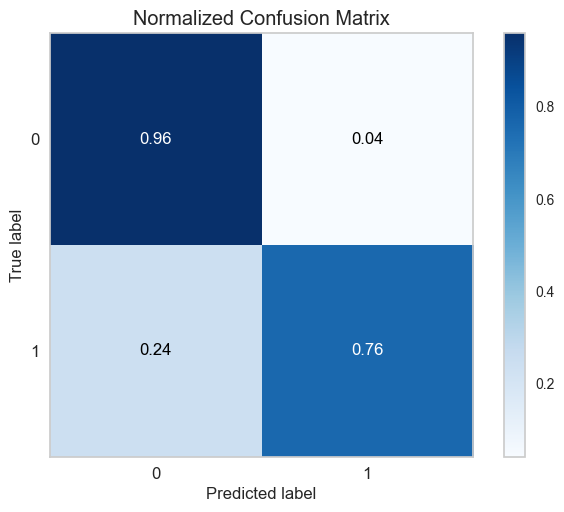

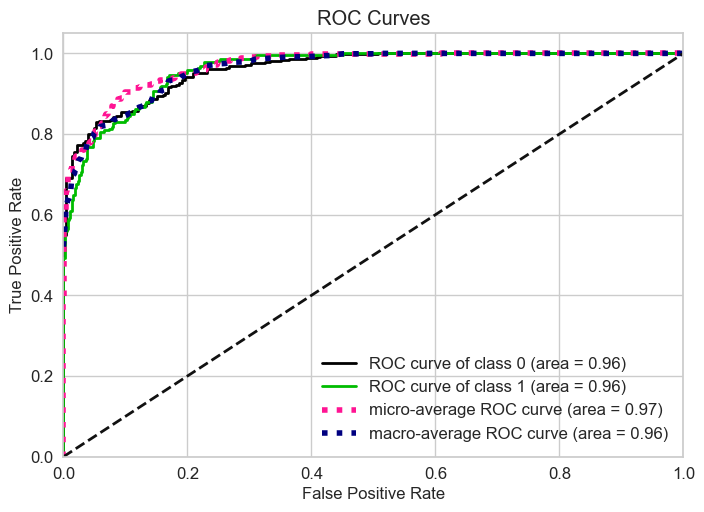

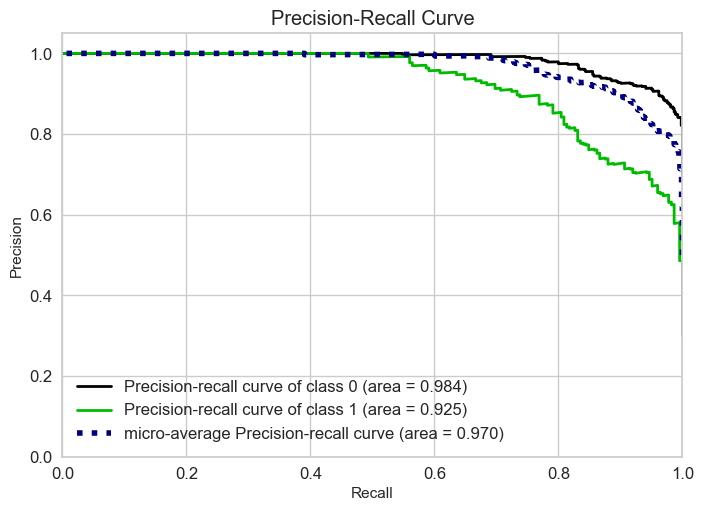

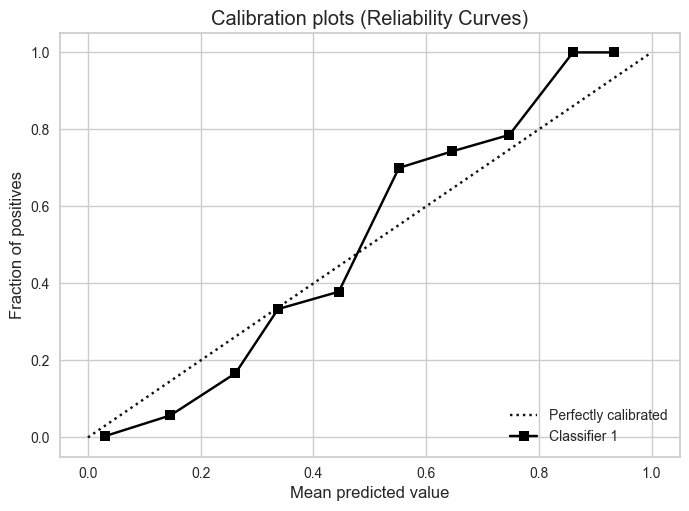

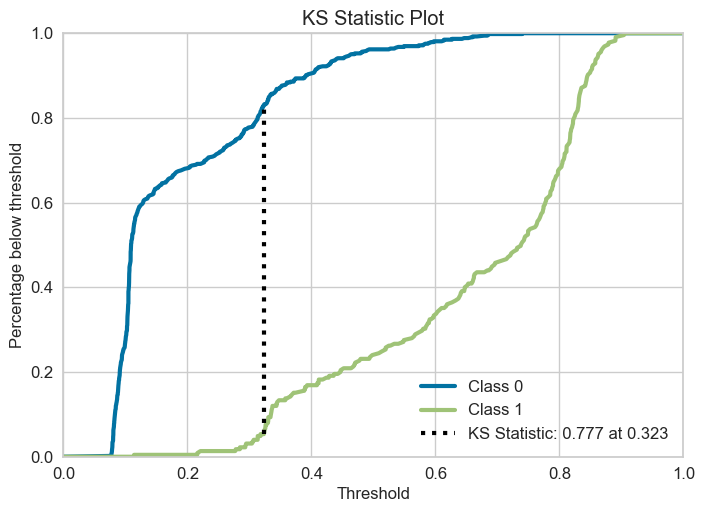

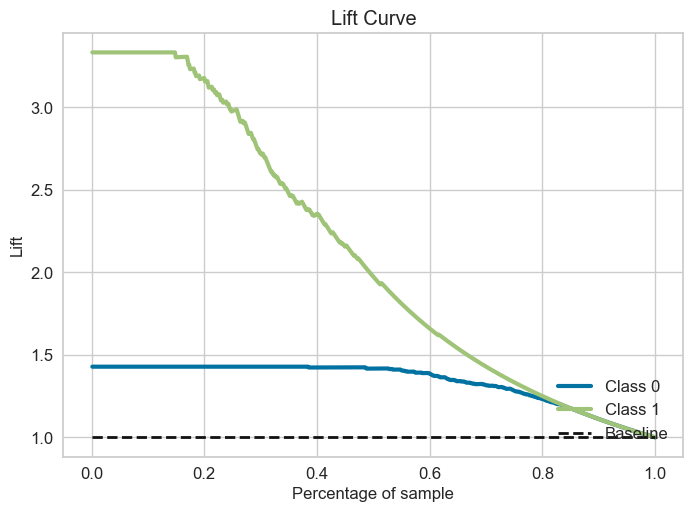

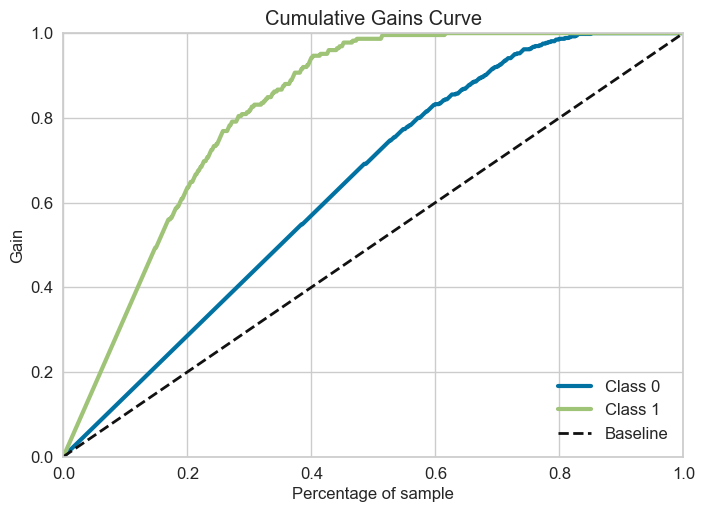

In [82]:
classifier_plots(y_train,y_probas_train1)

In [83]:
y_probas_train2 = clf2.predict_proba(X_train)

In [84]:
probas_list = [y_probas_train1[:,1],y_probas_train2[:,1]]
model_names = ['search1','search2']

In [85]:
plt1 = classifier_plots_int(y_train, probas_list, model_names)

In [86]:
plt1.keys()

dict_keys(['roc', 'pr', 'cal'])

In [87]:
plt1['roc'].show()

In [88]:
plt1['pr'].show()

In [89]:
plt1['cal'].show()

In [90]:
classifier_lift_df(y_train,y_probas_train1[:,1])

,bin,positive_count,total_count,fraction_of_positives,lift
0,0,75,75,1.000000,3.333333
1,1,68,75,0.906667,3.022222
2,2,41,75,0.546667,1.822222
3,3,28,75,0.373333,1.244444
4,4,10,75,0.133333,0.444444
5,5,2,75,0.026667,0.088889
6,6,1,75,0.013333,0.044444
7,7,0,75,0.000000,0.000000
8,8,0,75,0.000000,0.000000
9,9,0,75,0.000000,0.000000


In [91]:
lift_dfs, lift_plot = classifier_lift_plot(y_train,probas_list,model_names,show=True)